In [1]:
from tensorflow.keras.applications.vgg16 import VGG16
import time
from datetime import timedelta
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
import os

from util_functions import *

In [ ]:
IMG_SIZE = (224, 224)
DATA_PATH = "../../Data/"
IMAGES_PATH_VALIDATION = DATA_PATH+"HAM10000_images_separated_validation/"

In [2]:
def compile_vgg16() -> Sequential:
    '''
    This function compiles VGG16 CNN model
    Arguments:
        None
    Returns:
        VGG16 Sequential Model
    '''
    # Loading VGG16 model
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))
    base_model.trainable = False
    
    model = Sequential([
        layers.Rescaling(1./255, input_shape=(224,224,3)),
        base_model,

        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dense(512),
        layers.Dropout(0.4),
        layers.ReLU(),

        layers.Dense(512),
        layers.Dropout(0.4),
        layers.ReLU(),

        layers.Dense(7, activation="softmax")
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=['accuracy'],
    )
    return model

In [16]:
def execute_kfold(images_path: str, augmentation: str) -> None:
    '''
    This function executes KFold for VGG16 CNN model and prints statistics
    Arguments:
        images_path: path to images folder
        augmentation: type of augmentation
    Returns:
        None
    '''
    # Measure time of KFold
    start_time = time.time()
    epochs = 10
    batch_size = 64
    generator = ImageDataGenerator()
    
    # Create a dataframe with image id and lesion class to use in kfold split
    data = []
    for r, d, f in os.walk(images_path):
        for direc in d:
            for _,_,images in os.walk(os.path.join(images_path, direc)):
                for img_id in images:
                    data.append((direc,os.path.join(direc,img_id)))
    images_df = pd.DataFrame(data,columns=["dx","id"])
    
    # Perform KFold (Stratified ensures original data distribution)
    # Gather statistics
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    statistics_data = [[],[],[],[]]
    
    for train_index, test_index in kfold.split(images_df.id, images_df.dx):
        training_data = images_df.iloc[train_index]
        testing_data  = images_df.iloc[test_index]

        kfold_n = len(statistics_data[0])+1
        print("==> KFOLD :", kfold_n, "\n")

        training_set = generator.flow_from_dataframe(
                dataframe=training_data, directory=images_path,
                x_col="id", y_col="dx",
                class_mode="categorical", shuffle=True,
                target_size=IMG_SIZE, batch_size=batch_size,
                validate_filenames=False)

        testing_set = generator.flow_from_dataframe(
                dataframe=testing_data, directory=images_path,
                x_col="id", y_col="dx",
                class_mode="categorical", shuffle=False,
                target_size=IMG_SIZE, batch_size=batch_size,
                validate_filenames=False)

        model = compile_vgg16()
        fit_model(model, training_set, testing_set, epochs, verbose=True, 
                  augment="VGG16_{0}_kfold_{1}".format(augmentation, kfold_n))

        # Gather statistics
        train_evaluation = model.evaluate(training_set, verbose=0)
        validation_evaluation = model.evaluate(testing_set, verbose=0)

        statistics_data[0].append(train_evaluation[0]) # loss
        statistics_data[1].append(train_evaluation[1]) # accuracy
        statistics_data[2].append(validation_evaluation[0]) # val_loss
        statistics_data[3].append(validation_evaluation[1]) # val_accuracy

        #print_top_k_accuracy(model, testing_set)
        cm = print_confusion_matrix(model, IMAGES_PATH_VALIDATION, supress_print=True)
        print(cm.mean()[0:4], "\n")


    print("\n === KFOLD AVERAGE STATISTICS === ")
    print("loss: {0} - accuracy: {1} - val_loss: {2} - val_accuracy: {3}".format(
        np.average(statistics_data[0]), np.average(statistics_data[1]),
        np.average(statistics_data[2]), np.average(statistics_data[3])
    ))
    print("Time Elapsed : ", timedelta(seconds=(time.time() - start_time)))

In [4]:
augmentations_data_paths = {
    "original": DATA_PATH+"HAM10000_images_separated/",
    "rotation": DATA_PATH+"HAM10000_images_separated_rotated/",
    "crop+flip":DATA_PATH+"HAM10000_images_separated_cropped_flipped/",
    "zoom":     DATA_PATH+"HAM10000_images_separated_zoomed/",
    "color":    DATA_PATH+"HAM10000_images_separated_colored_RGB/"    
}

In [ ]:
# Loop will create too much output in one cell
# That is why we are calling image paths one by one
# Another reason, due to long period of time 
# there could be a system crash, power outage and other problems
# With separation we will be able to continue and not lose all the progress

==> KFOLD : 1 

Found 7208 non-validated image filenames belonging to 7 classes.
Found 1802 non-validated image filenames belonging to 7 classes.
Epoch 1/10
113/113 [==============================] - 550s 5s/step - loss: 1.2554 - accuracy: 0.6214 - val_loss: 1.5820 - val_accuracy: 0.6360
Epoch 2/10
113/113 [==============================] - 550s 5s/step - loss: 1.0267 - accuracy: 0.6663 - val_loss: 1.1760 - val_accuracy: 0.6798
Epoch 3/10
113/113 [==============================] - 548s 5s/step - loss: 0.9621 - accuracy: 0.6830 - val_loss: 0.9731 - val_accuracy: 0.6903
Epoch 4/10
113/113 [==============================] - 549s 5s/step - loss: 0.8951 - accuracy: 0.6996 - val_loss: 0.8905 - val_accuracy: 0.6931
Epoch 5/10
113/113 [==============================] - 548s 5s/step - loss: 0.8388 - accuracy: 0.7143 - val_loss: 0.8492 - val_accuracy: 0.7037
Epoch 6/10
113/113 [==============================] - 547s 5s/step - loss: 0.8040 - accuracy: 0.7267 - val_loss: 0.8248 - val_accuracy: 0.7

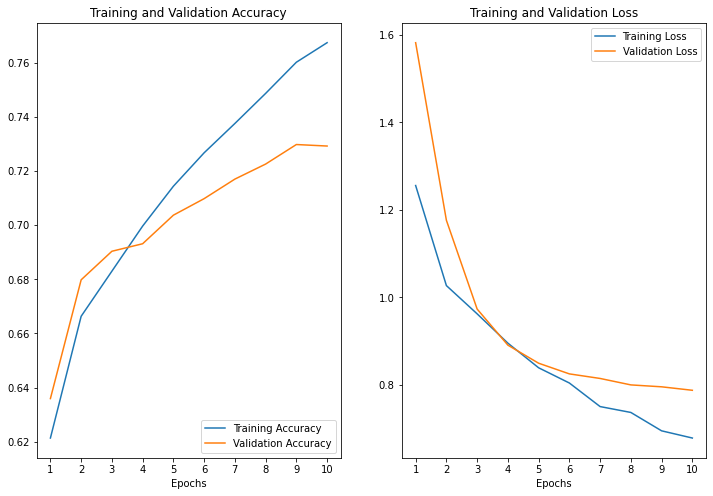

Top 1 accuracy : 0.7292
Top 2 accuracy : 0.8546
Top 3 accuracy : 0.9401
Top 4 accuracy : 0.9717
Top 5 accuracy : 0.9895
Found 1005 images belonging to 7 classes.
Accuracy Score :  0.7323
precision      0.622843
recall         0.279900
specificity    0.880529
f1-score       0.327886
dtype: float64 

==> KFOLD : 2 

Found 7208 non-validated image filenames belonging to 7 classes.
Found 1802 non-validated image filenames belonging to 7 classes.
Epoch 1/10
113/113 [==============================] - 542s 5s/step - loss: 1.2904 - accuracy: 0.6079 - val_loss: 1.5544 - val_accuracy: 0.6210
Epoch 2/10
113/113 [==============================] - 542s 5s/step - loss: 1.0264 - accuracy: 0.6686 - val_loss: 1.1571 - val_accuracy: 0.6754
Epoch 3/10
113/113 [==============================] - 544s 5s/step - loss: 0.9520 - accuracy: 0.6852 - val_loss: 0.9573 - val_accuracy: 0.6953
Epoch 4/10
113/113 [==============================] - 544s 5s/step - loss: 0.8833 - accuracy: 0.6971 - val_loss: 0.8660 - val

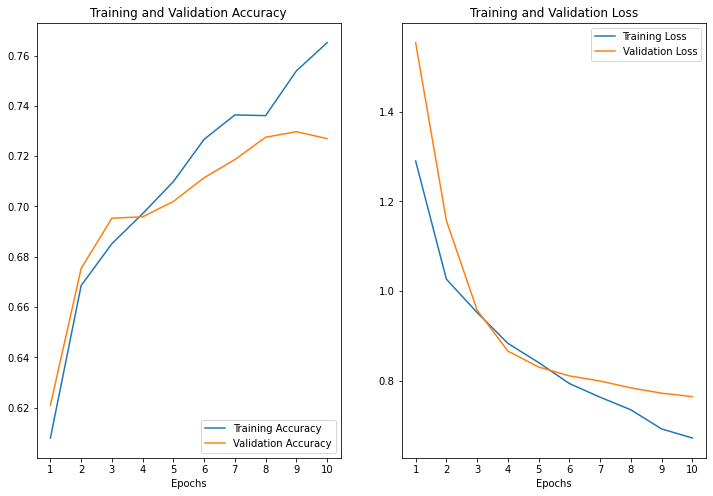

Top 1 accuracy : 0.727
Top 2 accuracy : 0.8602
Top 3 accuracy : 0.9384
Top 4 accuracy : 0.975
Top 5 accuracy : 0.9917
Found 1005 images belonging to 7 classes.
Accuracy Score :  0.7393
precision      0.457629
recall         0.284529
specificity    0.884171
f1-score       0.322457
dtype: float64 

==> KFOLD : 3 

Found 7208 non-validated image filenames belonging to 7 classes.
Found 1802 non-validated image filenames belonging to 7 classes.
Epoch 1/10
113/113 [==============================] - 547s 5s/step - loss: 1.2429 - accuracy: 0.6217 - val_loss: 1.4195 - val_accuracy: 0.6804
Epoch 2/10
113/113 [==============================] - 553s 5s/step - loss: 1.0128 - accuracy: 0.6755 - val_loss: 1.1723 - val_accuracy: 0.6926
Epoch 3/10
113/113 [==============================] - 557s 5s/step - loss: 0.9473 - accuracy: 0.6831 - val_loss: 0.9594 - val_accuracy: 0.7125
Epoch 4/10
113/113 [==============================] - 555s 5s/step - loss: 0.8860 - accuracy: 0.6973 - val_loss: 0.8432 - val_a

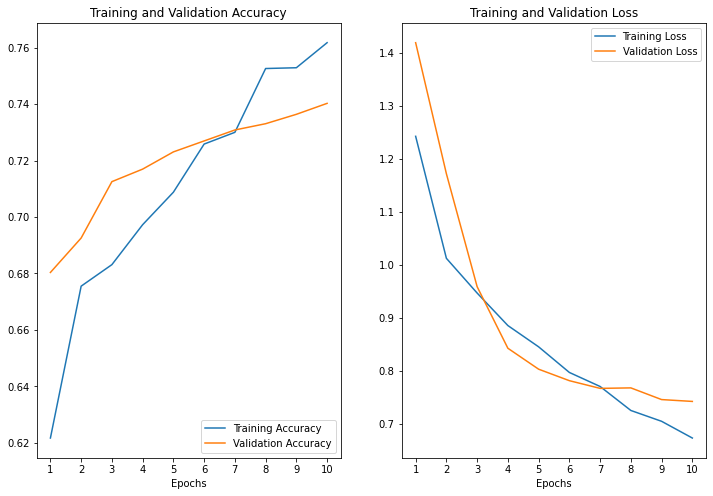

Top 1 accuracy : 0.7403
Top 2 accuracy : 0.8846
Top 3 accuracy : 0.9467
Top 4 accuracy : 0.9745
Top 5 accuracy : 0.9889
Found 1005 images belonging to 7 classes.
Accuracy Score :  0.7373
precision      0.555629
recall         0.333171
specificity    0.883186
f1-score       0.390643
dtype: float64 

==> KFOLD : 4 

Found 7208 non-validated image filenames belonging to 7 classes.
Found 1802 non-validated image filenames belonging to 7 classes.
Epoch 1/10
113/113 [==============================] - 553s 5s/step - loss: 1.2348 - accuracy: 0.6276 - val_loss: 1.3899 - val_accuracy: 0.6876
Epoch 2/10
113/113 [==============================] - 554s 5s/step - loss: 1.0240 - accuracy: 0.6706 - val_loss: 1.1269 - val_accuracy: 0.6898
Epoch 3/10
113/113 [==============================] - 552s 5s/step - loss: 0.9434 - accuracy: 0.6881 - val_loss: 0.9501 - val_accuracy: 0.7042
Epoch 4/10
113/113 [==============================] - 553s 5s/step - loss: 0.8902 - accuracy: 0.6980 - val_loss: 0.8580 - val

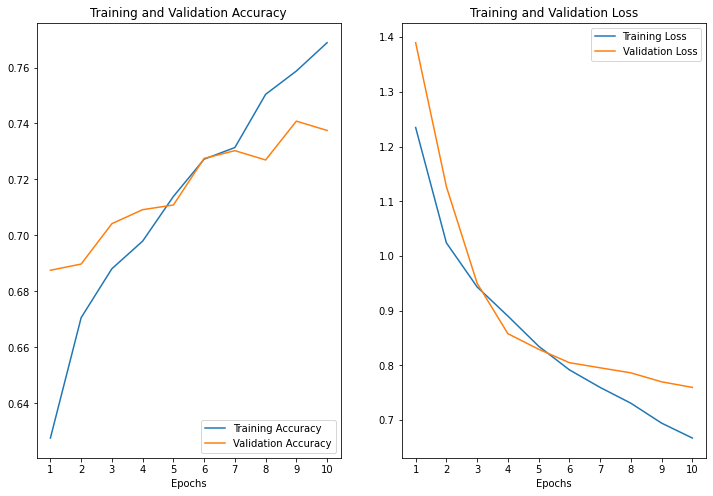

Top 1 accuracy : 0.7375
Top 2 accuracy : 0.8779
Top 3 accuracy : 0.9478
Top 4 accuracy : 0.9778
Top 5 accuracy : 0.99
Found 1005 images belonging to 7 classes.
Accuracy Score :  0.7493
precision      0.540929
recall         0.330114
specificity    0.889314
f1-score       0.383386
dtype: float64 

==> KFOLD : 5 

Found 7208 non-validated image filenames belonging to 7 classes.
Found 1802 non-validated image filenames belonging to 7 classes.
Epoch 1/10
113/113 [==============================] - 548s 5s/step - loss: 1.2665 - accuracy: 0.6111 - val_loss: 1.3691 - val_accuracy: 0.6676
Epoch 2/10
113/113 [==============================] - 557s 5s/step - loss: 1.0388 - accuracy: 0.6687 - val_loss: 1.1559 - val_accuracy: 0.6698
Epoch 3/10
113/113 [==============================] - 549s 5s/step - loss: 0.9511 - accuracy: 0.6858 - val_loss: 0.9551 - val_accuracy: 0.7042
Epoch 4/10
113/113 [==============================] - 556s 5s/step - loss: 0.8937 - accuracy: 0.6994 - val_loss: 0.8755 - val_a

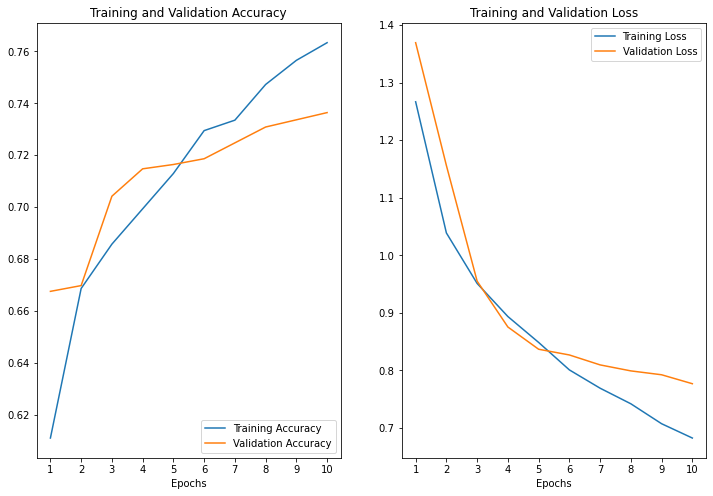

Top 1 accuracy : 0.7364
Top 2 accuracy : 0.8629
Top 3 accuracy : 0.9356
Top 4 accuracy : 0.9717
Top 5 accuracy : 0.9867
Found 1005 images belonging to 7 classes.
Accuracy Score :  0.7403
precision      0.525329
recall         0.297929
specificity    0.884429
f1-score       0.348114
dtype: float64 


 === KFOLD AVERAGE STATISTICS === 
loss: 0.5279057741165161 - accuracy: 0.8265538334846496 - val_loss: 0.7662869453430176 - val_accuracy: 0.734073257446289
Time Elapsed :  9:24:10.593799


In [5]:
augment = "original"
execute_kfold(augmentations_data_paths[augment], augment)

==> KFOLD : 1 

Found 15330 non-validated image filenames belonging to 7 classes.
Found 3833 non-validated image filenames belonging to 7 classes.
Epoch 1/10
240/240 [==============================] - 1199s 5s/step - loss: 1.6865 - accuracy: 0.3652 - val_loss: 1.4582 - val_accuracy: 0.5304
Epoch 2/10
240/240 [==============================] - 1180s 5s/step - loss: 1.3373 - accuracy: 0.4969 - val_loss: 1.1491 - val_accuracy: 0.5802
Epoch 3/10
240/240 [==============================] - 1194s 5s/step - loss: 1.1905 - accuracy: 0.5519 - val_loss: 1.0188 - val_accuracy: 0.6282
Epoch 4/10
240/240 [==============================] - 1179s 5s/step - loss: 1.0907 - accuracy: 0.5890 - val_loss: 0.9552 - val_accuracy: 0.6439
Epoch 5/10
240/240 [==============================] - 1184s 5s/step - loss: 1.0163 - accuracy: 0.6174 - val_loss: 0.9045 - val_accuracy: 0.6653
Epoch 6/10
240/240 [==============================] - 1178s 5s/step - loss: 0.9552 - accuracy: 0.6428 - val_loss: 0.8767 - val_accura

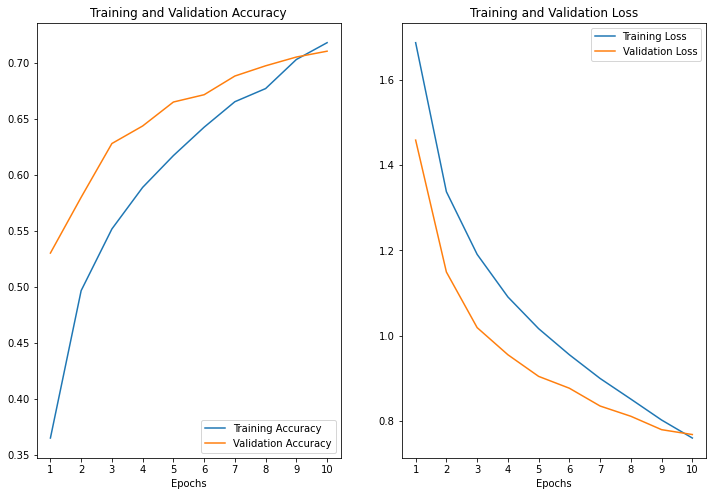

Top 1 accuracy : 0.7107
Top 2 accuracy : 0.8766
Top 3 accuracy : 0.9507
Top 4 accuracy : 0.9794
Top 5 accuracy : 0.9977
Found 1005 images belonging to 7 classes.
Accuracy Score :  0.7463
precision      0.545800
recall         0.414543
specificity    0.893257
f1-score       0.443900
dtype: float64 

==> KFOLD : 2 

Found 15330 non-validated image filenames belonging to 7 classes.
Found 3833 non-validated image filenames belonging to 7 classes.
Epoch 1/10
240/240 [==============================] - 1181s 5s/step - loss: 1.6888 - accuracy: 0.3697 - val_loss: 1.4666 - val_accuracy: 0.5367
Epoch 2/10
240/240 [==============================] - 1189s 5s/step - loss: 1.3439 - accuracy: 0.4933 - val_loss: 1.1509 - val_accuracy: 0.5935
Epoch 3/10
240/240 [==============================] - 1185s 5s/step - loss: 1.2009 - accuracy: 0.5515 - val_loss: 1.0245 - val_accuracy: 0.6165
Epoch 4/10
240/240 [==============================] - 1183s 5s/step - loss: 1.1031 - accuracy: 0.5830 - val_loss: 0.9591 

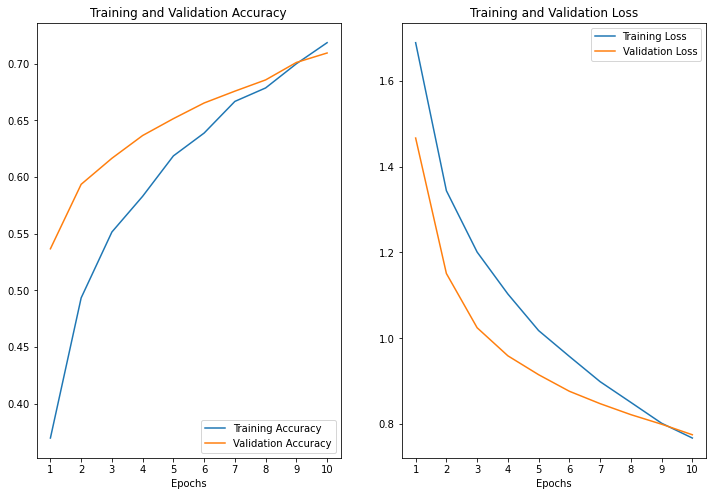

Top 1 accuracy : 0.7094
Top 2 accuracy : 0.8727
Top 3 accuracy : 0.9476
Top 4 accuracy : 0.9789
Top 5 accuracy : 0.9943
Found 1005 images belonging to 7 classes.
Accuracy Score :  0.7493
precision      0.513857
recall         0.414171
specificity    0.899914
f1-score       0.415000
dtype: float64 

==> KFOLD : 3 

Found 15330 non-validated image filenames belonging to 7 classes.
Found 3833 non-validated image filenames belonging to 7 classes.
Epoch 1/10
240/240 [==============================] - 1176s 5s/step - loss: 1.6813 - accuracy: 0.3701 - val_loss: 1.4523 - val_accuracy: 0.5474
Epoch 2/10
240/240 [==============================] - 1184s 5s/step - loss: 1.3209 - accuracy: 0.5058 - val_loss: 1.1431 - val_accuracy: 0.5974
Epoch 3/10
240/240 [==============================] - 1190s 5s/step - loss: 1.1834 - accuracy: 0.5571 - val_loss: 1.0291 - val_accuracy: 0.6243
Epoch 4/10
240/240 [==============================] - 1183s 5s/step - loss: 1.0841 - accuracy: 0.5927 - val_loss: 0.9649 

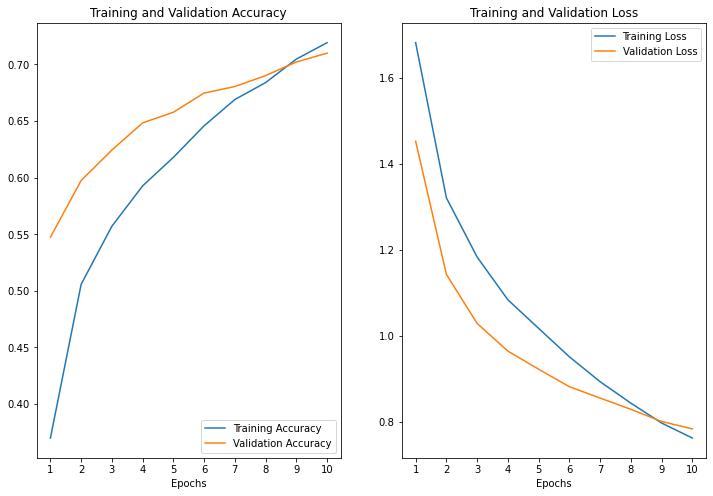

Top 1 accuracy : 0.7099
Top 2 accuracy : 0.8787
Top 3 accuracy : 0.9457
Top 4 accuracy : 0.9802
Top 5 accuracy : 0.995
Found 1005 images belonging to 7 classes.
Accuracy Score :  0.7592
precision      0.587757
recall         0.433557
specificity    0.900629
f1-score       0.447500
dtype: float64 

==> KFOLD : 4 

Found 15331 non-validated image filenames belonging to 7 classes.
Found 3832 non-validated image filenames belonging to 7 classes.
Epoch 1/10
240/240 [==============================] - 1239s 5s/step - loss: 1.6604 - accuracy: 0.3732 - val_loss: 1.4592 - val_accuracy: 0.5295
Epoch 2/10
240/240 [==============================] - 1182s 5s/step - loss: 1.3313 - accuracy: 0.4970 - val_loss: 1.1809 - val_accuracy: 0.5718
Epoch 3/10
240/240 [==============================] - 1189s 5s/step - loss: 1.1925 - accuracy: 0.5486 - val_loss: 1.0583 - val_accuracy: 0.6177
Epoch 4/10
240/240 [==============================] - 1184s 5s/step - loss: 1.0923 - accuracy: 0.5929 - val_loss: 1.0026 -

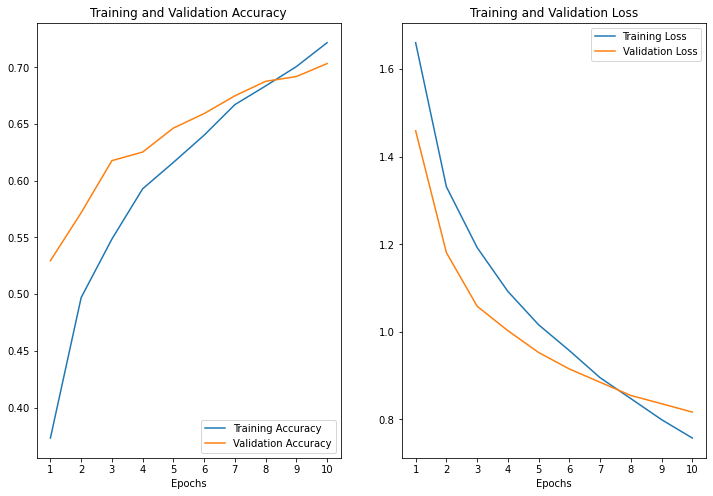

Top 1 accuracy : 0.7033
Top 2 accuracy : 0.8669
Top 3 accuracy : 0.9387
Top 4 accuracy : 0.9747
Top 5 accuracy : 0.993
Found 1005 images belonging to 7 classes.
Accuracy Score :  0.7532
precision      0.539229
recall         0.405629
specificity    0.897643
f1-score       0.426414
dtype: float64 

==> KFOLD : 5 

Found 15331 non-validated image filenames belonging to 7 classes.
Found 3832 non-validated image filenames belonging to 7 classes.
Epoch 1/10
240/240 [==============================] - 1195s 5s/step - loss: 1.6843 - accuracy: 0.3630 - val_loss: 1.4640 - val_accuracy: 0.5509
Epoch 2/10
240/240 [==============================] - 1183s 5s/step - loss: 1.3349 - accuracy: 0.4952 - val_loss: 1.1519 - val_accuracy: 0.6018
Epoch 3/10
240/240 [==============================] - 1193s 5s/step - loss: 1.1985 - accuracy: 0.5514 - val_loss: 1.0305 - val_accuracy: 0.6339
Epoch 4/10
240/240 [==============================] - 1189s 5s/step - loss: 1.0949 - accuracy: 0.5889 - val_loss: 0.9616 -

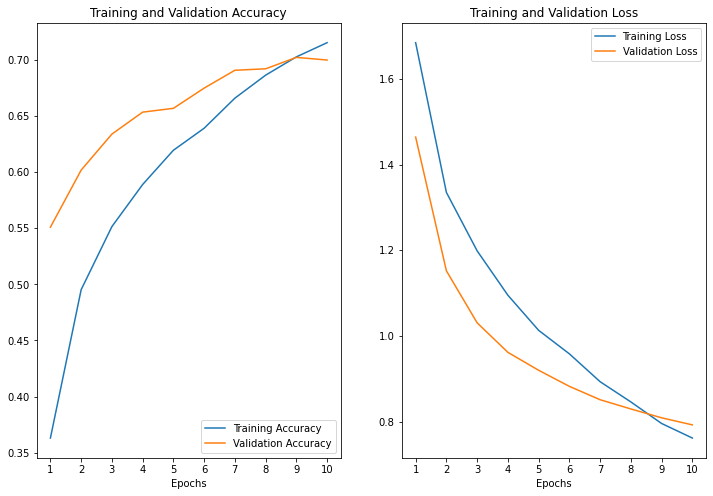

Top 1 accuracy : 0.6999
Top 2 accuracy : 0.8664
Top 3 accuracy : 0.9442
Top 4 accuracy : 0.9744
Top 5 accuracy : 0.9948
Found 1005 images belonging to 7 classes.
Accuracy Score :  0.7453
precision      0.562743
recall         0.418000
specificity    0.897371
f1-score       0.419386
dtype: float64 


 === KFOLD AVERAGE STATISTICS === 
loss: 0.5735341310501099 - accuracy: 0.8057193279266357 - val_loss: 0.7872811555862427 - val_accuracy: 0.7066215991973877
Time Elapsed :  20:08:06.803668


In [6]:
augment = "rotation"
execute_kfold(augmentations_data_paths[augment], augment)

==> KFOLD : 1 

Found 15330 non-validated image filenames belonging to 7 classes.
Found 3833 non-validated image filenames belonging to 7 classes.
Epoch 1/10
240/240 [==============================] - 1169s 5s/step - loss: 1.7017 - accuracy: 0.3646 - val_loss: 1.4766 - val_accuracy: 0.5440
Epoch 2/10
240/240 [==============================] - 1174s 5s/step - loss: 1.2943 - accuracy: 0.5187 - val_loss: 1.0837 - val_accuracy: 0.6329
Epoch 3/10
240/240 [==============================] - 1161s 5s/step - loss: 1.1120 - accuracy: 0.5877 - val_loss: 0.9394 - val_accuracy: 0.6572
Epoch 4/10
240/240 [==============================] - 1179s 5s/step - loss: 0.9955 - accuracy: 0.6286 - val_loss: 0.8676 - val_accuracy: 0.6809
Epoch 5/10
240/240 [==============================] - 1165s 5s/step - loss: 0.9120 - accuracy: 0.6631 - val_loss: 0.8136 - val_accuracy: 0.7026
Epoch 6/10
240/240 [==============================] - 1174s 5s/step - loss: 0.8381 - accuracy: 0.6898 - val_loss: 0.7757 - val_accura

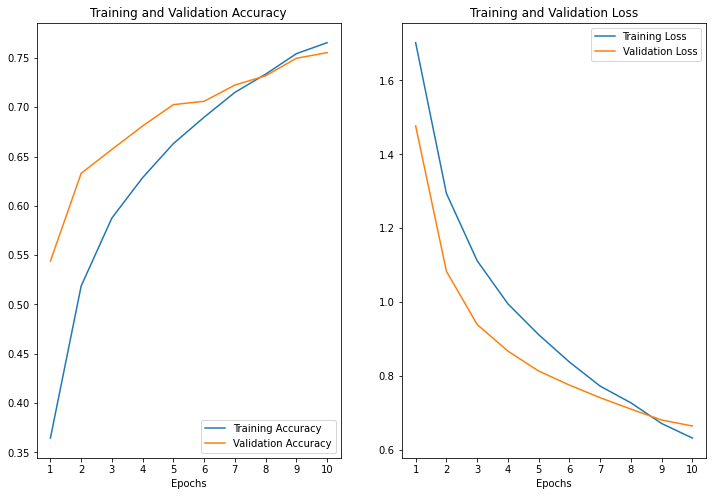

Top 1 accuracy : 0.7553
Top 2 accuracy : 0.9108
Top 3 accuracy : 0.9661
Top 4 accuracy : 0.989
Top 5 accuracy : 0.9963
Found 1005 images belonging to 7 classes.
Accuracy Score :  0.6239
precision      0.420957
recall         0.281000
specificity    0.849357
f1-score       0.292486
dtype: float64 

==> KFOLD : 2 

Found 15330 non-validated image filenames belonging to 7 classes.
Found 3833 non-validated image filenames belonging to 7 classes.
Epoch 1/10
240/240 [==============================] - 1185s 5s/step - loss: 1.7262 - accuracy: 0.3535 - val_loss: 1.4723 - val_accuracy: 0.5557
Epoch 2/10
240/240 [==============================] - 1166s 5s/step - loss: 1.2909 - accuracy: 0.5177 - val_loss: 1.0755 - val_accuracy: 0.6329
Epoch 3/10
240/240 [==============================] - 1182s 5s/step - loss: 1.1296 - accuracy: 0.5811 - val_loss: 0.9359 - val_accuracy: 0.6580
Epoch 4/10
240/240 [==============================] - 1172s 5s/step - loss: 1.0167 - accuracy: 0.6208 - val_loss: 0.8587 -

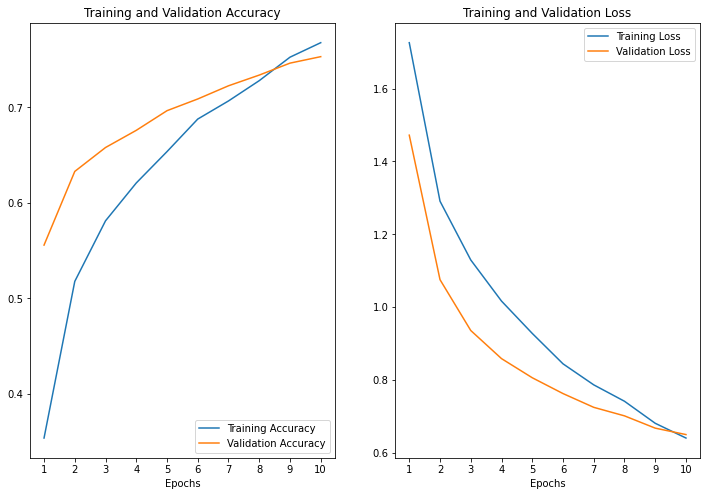

Top 1 accuracy : 0.7532
Top 2 accuracy : 0.9131
Top 3 accuracy : 0.9663
Top 4 accuracy : 0.9893
Top 5 accuracy : 0.9974
Found 1005 images belonging to 7 classes.
Accuracy Score :  0.6119
precision      0.392643
recall         0.282114
specificity    0.845386
f1-score       0.278829
dtype: float64 

==> KFOLD : 3 

Found 15330 non-validated image filenames belonging to 7 classes.
Found 3833 non-validated image filenames belonging to 7 classes.
Epoch 1/10
240/240 [==============================] - 1183s 5s/step - loss: 1.7292 - accuracy: 0.3579 - val_loss: 1.4825 - val_accuracy: 0.5588
Epoch 2/10
240/240 [==============================] - 1181s 5s/step - loss: 1.2993 - accuracy: 0.5181 - val_loss: 1.0889 - val_accuracy: 0.6368
Epoch 3/10
240/240 [==============================] - 1197s 5s/step - loss: 1.1204 - accuracy: 0.5806 - val_loss: 0.9373 - val_accuracy: 0.6676
Epoch 4/10
240/240 [==============================] - 1179s 5s/step - loss: 1.0050 - accuracy: 0.6292 - val_loss: 0.8645 

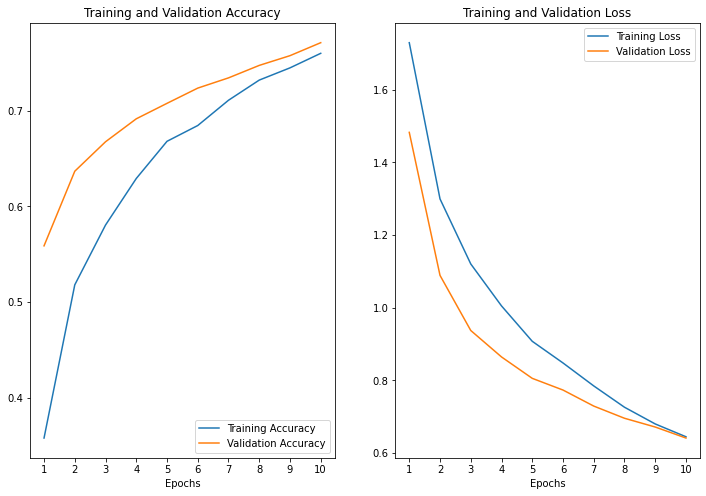

Top 1 accuracy : 0.7712
Top 2 accuracy : 0.9121
Top 3 accuracy : 0.9666
Top 4 accuracy : 0.9875
Top 5 accuracy : 0.9977
Found 1005 images belonging to 7 classes.
Accuracy Score :  0.6338
precision      0.473286
recall         0.309757
specificity    0.855843
f1-score       0.324857
dtype: float64 

==> KFOLD : 4 

Found 15331 non-validated image filenames belonging to 7 classes.
Found 3832 non-validated image filenames belonging to 7 classes.
Epoch 1/10
240/240 [==============================] - 1182s 5s/step - loss: 1.7184 - accuracy: 0.3610 - val_loss: 1.4778 - val_accuracy: 0.5274
Epoch 2/10
240/240 [==============================] - 1182s 5s/step - loss: 1.2910 - accuracy: 0.5153 - val_loss: 1.0816 - val_accuracy: 0.6268
Epoch 3/10
240/240 [==============================] - 1180s 5s/step - loss: 1.1062 - accuracy: 0.5885 - val_loss: 0.9325 - val_accuracy: 0.6584
Epoch 4/10
240/240 [==============================] - 1183s 5s/step - loss: 0.9958 - accuracy: 0.6252 - val_loss: 0.8677 

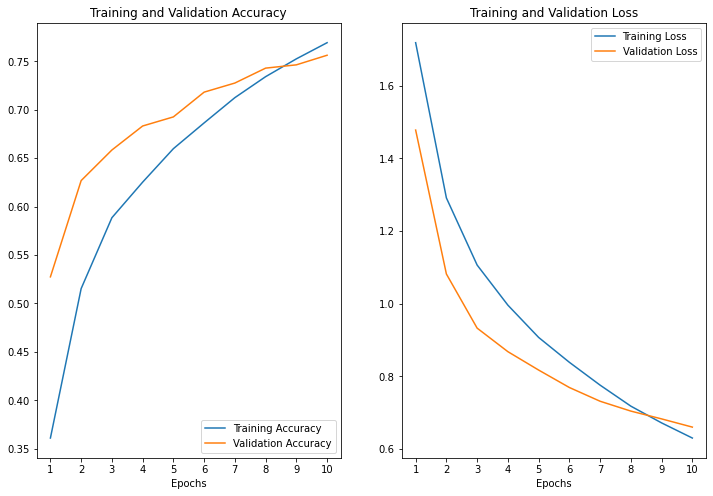

Top 1 accuracy : 0.7563
Top 2 accuracy : 0.9055
Top 3 accuracy : 0.9622
Top 4 accuracy : 0.9864
Top 5 accuracy : 0.994
Found 1005 images belonging to 7 classes.
Accuracy Score :  0.6249
precision      0.432657
recall         0.282386
specificity    0.851329
f1-score       0.307643
dtype: float64 

==> KFOLD : 5 

Found 15331 non-validated image filenames belonging to 7 classes.
Found 3832 non-validated image filenames belonging to 7 classes.
Epoch 1/10
240/240 [==============================] - 1234s 5s/step - loss: 1.7825 - accuracy: 0.3390 - val_loss: 1.4983 - val_accuracy: 0.5517
Epoch 2/10
240/240 [==============================] - 1374s 6s/step - loss: 1.3075 - accuracy: 0.5136 - val_loss: 1.0968 - val_accuracy: 0.6164
Epoch 3/10
240/240 [==============================] - 1437s 6s/step - loss: 1.1336 - accuracy: 0.5781 - val_loss: 0.9594 - val_accuracy: 0.6375
Epoch 4/10
240/240 [==============================] - 1427s 6s/step - loss: 1.0167 - accuracy: 0.6187 - val_loss: 0.8816 -

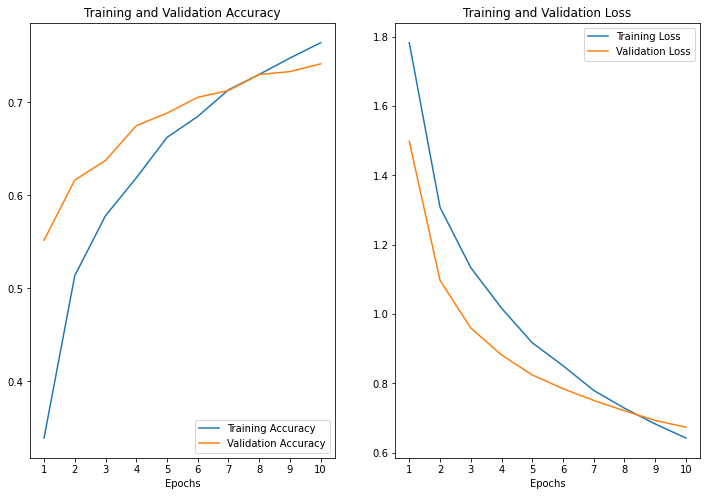

Top 1 accuracy : 0.7414
Top 2 accuracy : 0.9066
Top 3 accuracy : 0.9656
Top 4 accuracy : 0.9901
Top 5 accuracy : 0.9971
Found 1005 images belonging to 7 classes.
Accuracy Score :  0.6398
precision      0.422129
recall         0.256429
specificity    0.852714
f1-score       0.283743
dtype: float64 


 === KFOLD AVERAGE STATISTICS === 
loss: 0.44746690392494204 - accuracy: 0.8523717403411866 - val_loss: 0.6579046368598938 - val_accuracy: 0.7554655790328979
Time Elapsed :  20:50:36.768269


In [7]:
augment = "crop+flip"
execute_kfold(augmentations_data_paths[augment], augment)

==> KFOLD : 1 

Found 15330 non-validated image filenames belonging to 7 classes.
Found 3833 non-validated image filenames belonging to 7 classes.
Epoch 1/10
240/240 [==============================] - 1221s 5s/step - loss: 1.8140 - accuracy: 0.2992 - val_loss: 1.6234 - val_accuracy: 0.4785
Epoch 2/10
240/240 [==============================] - 1208s 5s/step - loss: 1.4367 - accuracy: 0.4543 - val_loss: 1.2432 - val_accuracy: 0.5849
Epoch 3/10
240/240 [==============================] - 1210s 5s/step - loss: 1.2481 - accuracy: 0.5339 - val_loss: 1.0426 - val_accuracy: 0.6431
Epoch 4/10
240/240 [==============================] - 1210s 5s/step - loss: 1.1134 - accuracy: 0.5856 - val_loss: 0.9329 - val_accuracy: 0.6809
Epoch 5/10
240/240 [==============================] - 1211s 5s/step - loss: 1.0064 - accuracy: 0.6292 - val_loss: 0.8544 - val_accuracy: 0.7094
Epoch 6/10
240/240 [==============================] - 1209s 5s/step - loss: 0.9133 - accuracy: 0.6655 - val_loss: 0.7920 - val_accura

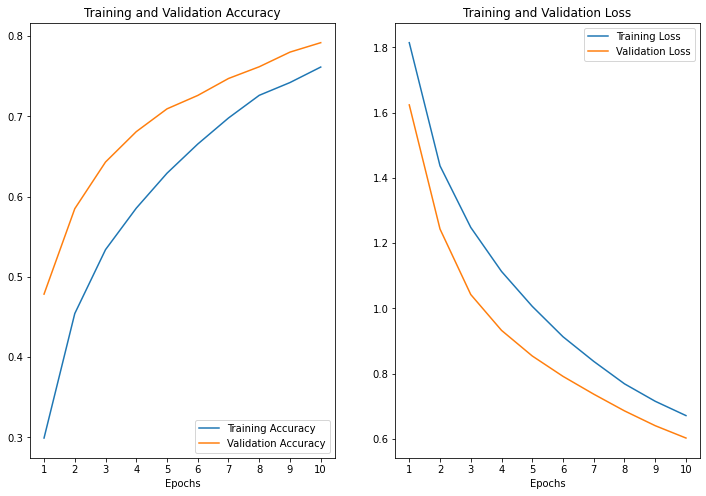

Top 1 accuracy : 0.7918
Top 2 accuracy : 0.9243
Top 3 accuracy : 0.9716
Top 4 accuracy : 0.9917
Top 5 accuracy : 0.9966
Found 1005 images belonging to 7 classes.
Accuracy Score :  0.7214
precision      0.447271
recall         0.425257
specificity    0.886000
f1-score       0.411143
dtype: float64 

==> KFOLD : 2 

Found 15330 non-validated image filenames belonging to 7 classes.
Found 3833 non-validated image filenames belonging to 7 classes.
Epoch 1/10
240/240 [==============================] - 1195s 5s/step - loss: 1.7904 - accuracy: 0.3177 - val_loss: 1.6130 - val_accuracy: 0.4633
Epoch 2/10
240/240 [==============================] - 1195s 5s/step - loss: 1.4195 - accuracy: 0.4617 - val_loss: 1.2499 - val_accuracy: 0.5740
Epoch 3/10
240/240 [==============================] - 1202s 5s/step - loss: 1.2300 - accuracy: 0.5425 - val_loss: 1.0596 - val_accuracy: 0.6285
Epoch 4/10
240/240 [==============================] - 1207s 5s/step - loss: 1.0978 - accuracy: 0.5913 - val_loss: 0.9512 

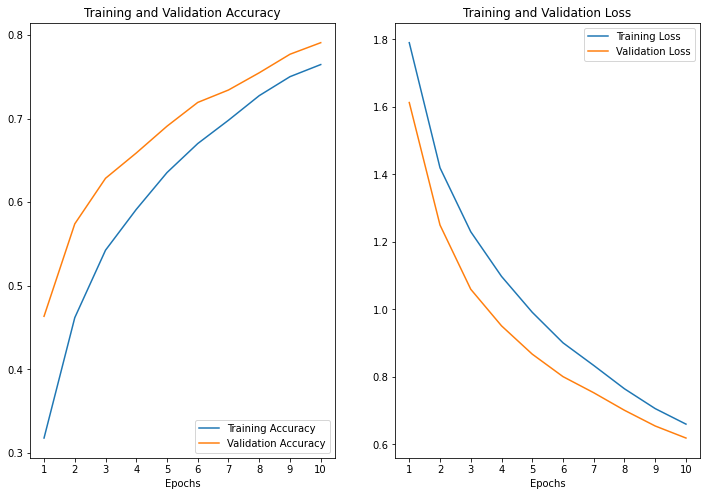

Top 1 accuracy : 0.7908
Top 2 accuracy : 0.9277
Top 3 accuracy : 0.9757
Top 4 accuracy : 0.9927
Top 5 accuracy : 0.9974
Found 1005 images belonging to 7 classes.
Accuracy Score :  0.7194
precision      0.449929
recall         0.436786
specificity    0.888929
f1-score       0.419129
dtype: float64 

==> KFOLD : 3 

Found 15330 non-validated image filenames belonging to 7 classes.
Found 3833 non-validated image filenames belonging to 7 classes.
Epoch 1/10
240/240 [==============================] - 1207s 5s/step - loss: 1.8003 - accuracy: 0.3143 - val_loss: 1.6117 - val_accuracy: 0.4868
Epoch 2/10
240/240 [==============================] - 1221s 5s/step - loss: 1.4227 - accuracy: 0.4598 - val_loss: 1.2239 - val_accuracy: 0.5912
Epoch 3/10
240/240 [==============================] - 1244s 5s/step - loss: 1.2493 - accuracy: 0.5327 - val_loss: 1.0287 - val_accuracy: 0.6423
Epoch 4/10
240/240 [==============================] - 1245s 5s/step - loss: 1.1122 - accuracy: 0.5867 - val_loss: 0.9218 

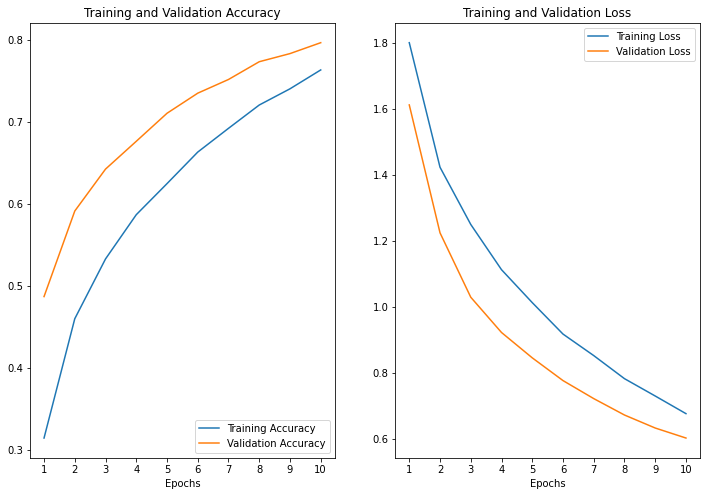

Top 1 accuracy : 0.7965
Top 2 accuracy : 0.9256
Top 3 accuracy : 0.9708
Top 4 accuracy : 0.994
Top 5 accuracy : 0.9979
Found 1005 images belonging to 7 classes.
Accuracy Score :  0.7363
precision      0.479529
recall         0.462229
specificity    0.892786
f1-score       0.440871
dtype: float64 

==> KFOLD : 4 

Found 15331 non-validated image filenames belonging to 7 classes.
Found 3832 non-validated image filenames belonging to 7 classes.
Epoch 1/10
240/240 [==============================] - 1292s 5s/step - loss: 1.7927 - accuracy: 0.3103 - val_loss: 1.6138 - val_accuracy: 0.4883
Epoch 2/10
240/240 [==============================] - 1289s 5s/step - loss: 1.4319 - accuracy: 0.4560 - val_loss: 1.2512 - val_accuracy: 0.5765
Epoch 3/10
240/240 [==============================] - 1252s 5s/step - loss: 1.2418 - accuracy: 0.5336 - val_loss: 1.0566 - val_accuracy: 0.6234
Epoch 4/10
240/240 [==============================] - 1306s 5s/step - loss: 1.1107 - accuracy: 0.5846 - val_loss: 0.9446 -

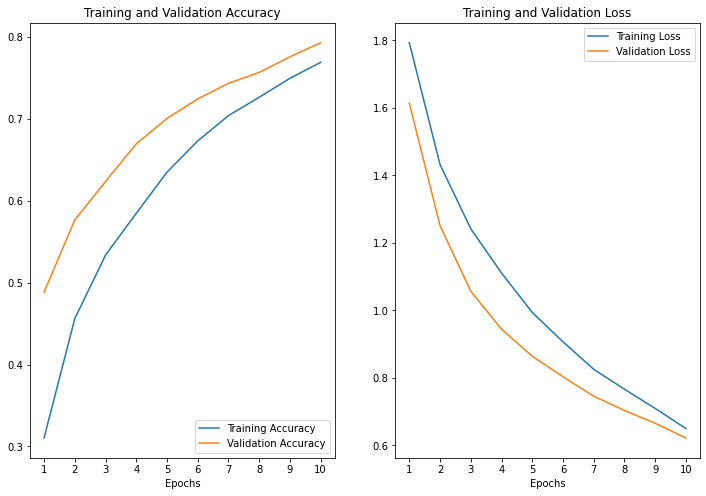

Top 1 accuracy : 0.7928
Top 2 accuracy : 0.9144
Top 3 accuracy : 0.9619
Top 4 accuracy : 0.988
Top 5 accuracy : 0.9974
Found 1005 images belonging to 7 classes.
Accuracy Score :  0.7244
precision      0.475100
recall         0.454900
specificity    0.887871
f1-score       0.434100
dtype: float64 

==> KFOLD : 5 

Found 15331 non-validated image filenames belonging to 7 classes.
Found 3832 non-validated image filenames belonging to 7 classes.
Epoch 1/10
240/240 [==============================] - 1222s 5s/step - loss: 1.8082 - accuracy: 0.3062 - val_loss: 1.6174 - val_accuracy: 0.4661
Epoch 2/10
240/240 [==============================] - 1215s 5s/step - loss: 1.4276 - accuracy: 0.4600 - val_loss: 1.2420 - val_accuracy: 0.5775
Epoch 3/10
240/240 [==============================] - 1208s 5s/step - loss: 1.2359 - accuracy: 0.5382 - val_loss: 1.0631 - val_accuracy: 0.6258
Epoch 4/10
240/240 [==============================] - 1210s 5s/step - loss: 1.1068 - accuracy: 0.5972 - val_loss: 0.9602 -

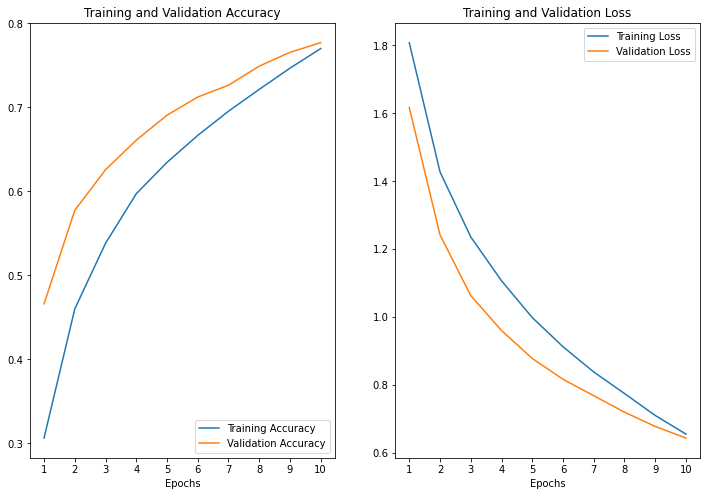

Top 1 accuracy : 0.7771
Top 2 accuracy : 0.9144
Top 3 accuracy : 0.9674
Top 4 accuracy : 0.9906
Top 5 accuracy : 0.9982
Found 1005 images belonging to 7 classes.
Accuracy Score :  0.7284
precision      0.469914
recall         0.454700
specificity    0.891286
f1-score       0.434314
dtype: float64 


 === KFOLD AVERAGE STATISTICS === 
loss: 0.46059417724609375 - accuracy: 0.8601601362228394 - val_loss: 0.6177803993225097 - val_accuracy: 0.7898027658462524
Time Elapsed :  20:55:54.988918


In [8]:
augment = "zoom"
execute_kfold(augmentations_data_paths[augment], augment)

==> KFOLD : 1 

Found 15330 non-validated image filenames belonging to 7 classes.
Found 3833 non-validated image filenames belonging to 7 classes.
Epoch 1/10
240/240 [==============================] - 1244s 5s/step - loss: 1.6112 - accuracy: 0.4097 - val_loss: 1.2751 - val_accuracy: 0.6175
Epoch 2/10
240/240 [==============================] - 1235s 5s/step - loss: 1.1252 - accuracy: 0.5728 - val_loss: 0.8760 - val_accuracy: 0.7141
Epoch 3/10
240/240 [==============================] - 1211s 5s/step - loss: 0.9300 - accuracy: 0.6486 - val_loss: 0.7106 - val_accuracy: 0.7605
Epoch 4/10
240/240 [==============================] - 1234s 5s/step - loss: 0.8004 - accuracy: 0.7035 - val_loss: 0.6142 - val_accuracy: 0.7994
Epoch 5/10
240/240 [==============================] - 1193s 5s/step - loss: 0.7088 - accuracy: 0.7399 - val_loss: 0.5480 - val_accuracy: 0.8229
Epoch 6/10
240/240 [==============================] - 1306s 5s/step - loss: 0.6294 - accuracy: 0.7710 - val_loss: 0.4930 - val_accura

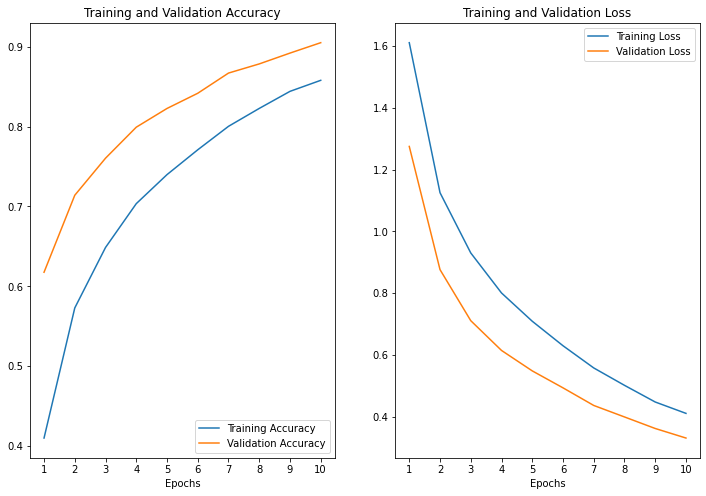

Found 1005 images belonging to 7 classes.
Accuracy Score :  0.6697
precision      0.262386
recall         0.152471
specificity    0.858000
f1-score       0.133100
dtype: float64 

==> KFOLD : 2 

Found 15330 non-validated image filenames belonging to 7 classes.
Found 3833 non-validated image filenames belonging to 7 classes.
Epoch 1/10
240/240 [==============================] - 1159s 5s/step - loss: 1.6083 - accuracy: 0.4155 - val_loss: 1.2571 - val_accuracy: 0.6076
Epoch 2/10
240/240 [==============================] - 1185s 5s/step - loss: 1.1110 - accuracy: 0.5765 - val_loss: 0.8830 - val_accuracy: 0.6914
Epoch 3/10
240/240 [==============================] - 1198s 5s/step - loss: 0.9157 - accuracy: 0.6542 - val_loss: 0.7220 - val_accuracy: 0.7532
Epoch 4/10
240/240 [==============================] - 1195s 5s/step - loss: 0.7928 - accuracy: 0.7003 - val_loss: 0.6333 - val_accuracy: 0.7816
Epoch 5/10
240/240 [==============================] - 1197s 5s/step - loss: 0.6982 - accuracy: 0.

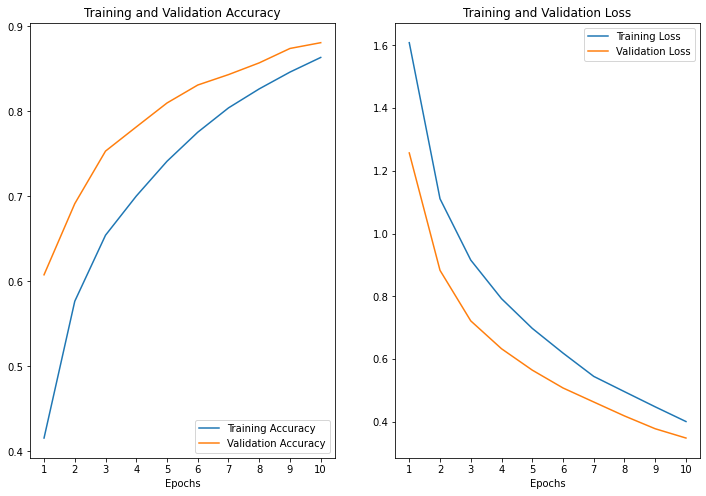

Found 1005 images belonging to 7 classes.
Accuracy Score :  0.6706
precision      0.286386
recall         0.150743
specificity    0.858214
f1-score       0.130143
dtype: float64 

==> KFOLD : 3 

Found 15330 non-validated image filenames belonging to 7 classes.
Found 3833 non-validated image filenames belonging to 7 classes.
Epoch 1/10
240/240 [==============================] - 1481s 6s/step - loss: 1.5632 - accuracy: 0.4258 - val_loss: 1.2485 - val_accuracy: 0.6027
Epoch 2/10
240/240 [==============================] - 1374s 6s/step - loss: 1.0959 - accuracy: 0.5808 - val_loss: 0.8709 - val_accuracy: 0.7013
Epoch 3/10
240/240 [==============================] - 1409s 6s/step - loss: 0.9073 - accuracy: 0.6554 - val_loss: 0.7239 - val_accuracy: 0.7529
Epoch 4/10
240/240 [==============================] - 1354s 6s/step - loss: 0.7917 - accuracy: 0.7072 - val_loss: 0.6274 - val_accuracy: 0.7926
Epoch 5/10
240/240 [==============================] - 1384s 6s/step - loss: 0.7023 - accuracy: 0.

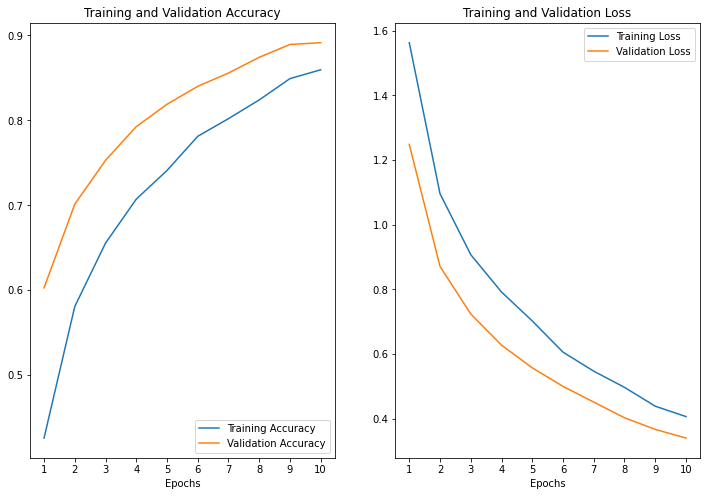

Found 1005 images belonging to 7 classes.
Accuracy Score :  0.6706
precision      0.381386
recall         0.152686
specificity    0.858429
f1-score       0.133586
dtype: float64 

==> KFOLD : 4 

Found 15331 non-validated image filenames belonging to 7 classes.
Found 3832 non-validated image filenames belonging to 7 classes.
Epoch 1/10
240/240 [==============================] - 1270s 5s/step - loss: 1.6093 - accuracy: 0.4190 - val_loss: 1.2868 - val_accuracy: 0.6143
Epoch 2/10
240/240 [==============================] - 1259s 5s/step - loss: 1.1136 - accuracy: 0.5775 - val_loss: 0.8882 - val_accuracy: 0.6955
Epoch 3/10
240/240 [==============================] - 1256s 5s/step - loss: 0.9256 - accuracy: 0.6504 - val_loss: 0.7272 - val_accuracy: 0.7474
Epoch 4/10
240/240 [==============================] - 1247s 5s/step - loss: 0.7995 - accuracy: 0.7041 - val_loss: 0.6350 - val_accuracy: 0.7787
Epoch 5/10
240/240 [==============================] - 1253s 5s/step - loss: 0.6938 - accuracy: 0.

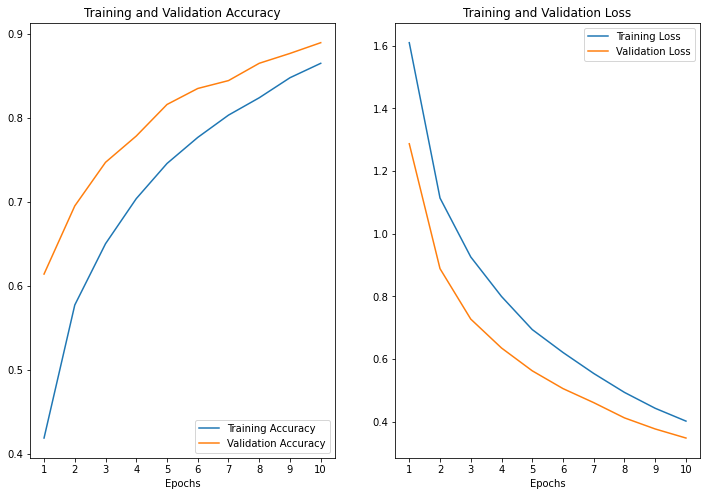

Found 1005 images belonging to 7 classes.
Accuracy Score :  0.6716
precision      0.476814
recall         0.153986
specificity    0.858643
f1-score       0.136086
dtype: float64 

==> KFOLD : 5 

Found 15331 non-validated image filenames belonging to 7 classes.
Found 3832 non-validated image filenames belonging to 7 classes.
Epoch 1/10
240/240 [==============================] - 1226s 5s/step - loss: 1.5793 - accuracy: 0.4180 - val_loss: 1.2858 - val_accuracy: 0.6073
Epoch 2/10
240/240 [==============================] - 1242s 5s/step - loss: 1.1031 - accuracy: 0.5835 - val_loss: 0.8889 - val_accuracy: 0.6955
Epoch 3/10
240/240 [==============================] - 1226s 5s/step - loss: 0.9209 - accuracy: 0.6551 - val_loss: 0.7295 - val_accuracy: 0.7500
Epoch 4/10
240/240 [==============================] - 1208s 5s/step - loss: 0.7914 - accuracy: 0.7046 - val_loss: 0.6300 - val_accuracy: 0.7847
Epoch 5/10
240/240 [==============================] - 1231s 5s/step - loss: 0.6980 - accuracy: 0.

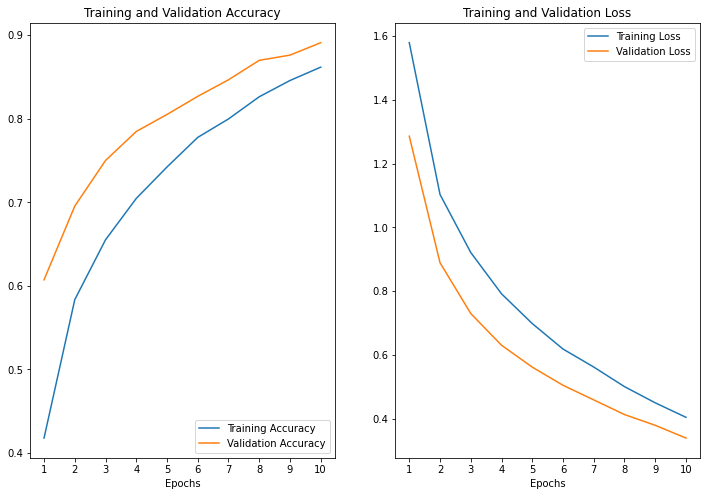

Found 1005 images belonging to 7 classes.
Accuracy Score :  0.6697
precision      0.405386
recall         0.153557
specificity    0.858000
f1-score       0.135714
dtype: float64 


 === KFOLD AVERAGE STATISTICS === 
loss: 0.2536791503429413 - accuracy: 0.9312867879867553 - val_loss: 0.34111742973327636 - val_accuracy: 0.8916660904884338
Time Elapsed :  21:16:04.755355


In [17]:
augment = "color"
execute_kfold(augmentations_data_paths[augment], augment)